<a href="https://colab.research.google.com/github/husseinfawaz20/QoT/blob/main/QoT_Regression_Samples.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Importing Libraries**

In [1]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns, os
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from xgboost import XGBRegressor
from statsmodels.api import OLS
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)

# **Data Visualization**

**Read Dataset**

In [2]:
df = pd.read_csv('DS_LPLevel_10100_Het_CFEGN_v3.csv')
target = 'Lightpath GSNR'
# df.head()
df.describe()

,Modulation Format Level,Link Number,Mean Spans Lengths,Max Spans Lengths,Min Spans Lengths,STD Spans Lengths,Ligthpath Total Traffic Load,Mean Links Traffic Load,Max Links Traffic Load,Min Links Traffic Load,...,STD Right Hand Links Idle Neighbours,Mean Left Hand Links Traffic Load,Max Left Hand Links Traffic Load,Min Left Hand Links Traffic Load,STD Left Hand Likns Traffic Load,Mean Left Hand Links Idle Neighbours,Max Left Hand Links Idle Neighbours,Min Left Hand Links Idle Neighbours,STD Left Hand Links Idle Neighbours,Lightpath GSNR
count,9594.000000,9594.000000,9594.000000,9594.000000,9594.000000,9594.000000,9594.000000,9594.000000,9594.000000,9594.000000,...,9594.000000,9594.000000,9594.000000,9594.000000,9594.000000,9594.000000,9594.000000,9594.000000,9594.000000,9594.000000
mean,3.400146,4.335001,83.706802,108.900459,59.330728,17.776051,80.295219,55.497410,96.040324,15.041983,...,1.139078,1.243674,3.126642,0.503231,1.109284,54.503279,72.890162,35.450141,16.599784,15.559814
std,1.662522,4.353518,9.194108,14.396646,13.673668,7.401017,25.313409,5.632466,3.976395,4.013714,...,1.726157,1.908195,4.106971,1.725400,1.653911,21.613158,27.566358,27.574336,15.370146,6.246934
min,1.000000,1.000000,50.000000,50.000000,50.000000,0.000000,10.169000,15.254000,15.254000,10.169000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.520300
25%,2.000000,1.000000,79.571000,104.000000,51.000000,16.266250,66.102000,51.780000,94.915000,11.864000,...,0.000000,0.000000,0.000000,0.000000,0.000000,42.647000,56.522000,14.286000,0.000000,10.290250
50%,3.000000,2.000000,83.986000,115.000000,53.000000,19.751000,93.220000,55.508000,96.610000,13.559000,...,0.547720,0.800000,2.000000,0.000000,0.534520,55.112500,82.759000,27.273000,18.461000,15.153000
75%,5.000000,6.000000,87.780750,119.000000,62.000000,21.636500,100.000000,59.322000,98.305000,16.949000,...,1.653100,1.666700,4.000000,0.000000,1.641325,66.794750,95.652000,52.778000,28.350000,20.039000
max,6.000000,20.000000,120.000000,120.000000,120.000000,48.083000,100.000000,76.356000,100.000000,40.678000,...,20.506000,30.000000,34.000000,30.000000,21.920000,100.000000,100.000000,100.000000,70.711000,33.020000


In [ ]:
f, ax = plt.subplots(figsize=(10, 8))
corr = df.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=bool),
            cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

In [ ]:
f1=df[['Modulation Format Level',	'Link Number',	'Mean Spans Lengths',	'Max Spans Lengths']]
f1.hist(figsize = (12,10))


feature= 'Mean Spans Lengths'
target = 'Lightpath GSNR'

plt.xlabel(feature)
plt.ylabel(target)

# #Scatter Plot:
# plt.scatter(df[feature], df[target])
# plt.title('Scatter Plot of Feature1 vs Lightpath GSNR')

# # Pairwise Scatter Plot:
# sns.pairplot(df[['Modulation Format Level',	'Link Number',	'Mean Spans Lengths',	'Max Spans Lengths', target]])

# Regression Line Plot:
# sns.regplot(data=df, x=target, y=feature)
# plt.title('Regression Line Plot of Feature1 vs Lightpath GSNR')

#Histograms and Density Plots:
# plt.hist(df[feature], bins=20)
# plt.title('Histogram of Feature1')

# Correlation Heatmap:
# correlation_matrix = df.corr()
# sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
# plt.title('Correlation Heatmap')


##Train / Test

In [37]:
X = df.drop([target], axis=1)
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [38]:
def getResults(y_test,y_pred,index):
  r2 = float(format((r2_score(y_test,y_pred)),'.3f'))
  rmse = float(format(np.sqrt(mean_squared_error(y_test, y_pred)),'.3f'))
  MAE = float(format((mean_absolute_error(y_test , y_pred)),'.3f'))
  dt = pd.DataFrame({'type': [index],'rmse': [rmse], 'mae': [MAE], 'r2' : [r2]})
  if os.path.isfile('results.csv'):
    dt.to_csv('results.csv',mode="a", header=False)
  else:
        dt.to_csv('results.csv')

**Scale Data**

In [39]:
scaler = StandardScaler()
scaler.fit(X_train)
train_scaled = scaler.transform(X_train)
test_scaled = scaler.transform(X_test)
X_train = pd.DataFrame(train_scaled, columns = X_train.columns)
X_test = pd.DataFrame(test_scaled, columns = X_test.columns)

# **Regression Models**

**XGB Regressor with Grid Search and CV=5**

In [26]:
xgb = XGBRegressor()

#LPLevel Dataset Params
params = {
              'objective':['reg:squarederror'],
              'gamma': [0.1],
              'learning_rate': [.03],
              'max_depth': [4],
              'min_child_weight': [1],
              'subsample': [0.5],
              'colsample_bytree': [0.3],
              'n_estimators': [500],'reg_alpha' : [0.01], 'reg_lambda' : [0.1]}

grid_search = GridSearchCV(xgb, params, cv=5,scoring = 'r2')
grid_search.fit(X_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_}")

best_clf = grid_search.best_estimator_
y_pred = best_clf.predict(X_test)
getResults(y_test,y_pred,"XGB with GridSearch")

**XGB Regressor**

In [40]:
xgb = XGBRegressor()
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
getResults(y_test,y_pred,"XGB")

**Decision Tree Regressor**

In [36]:
from sklearn.tree import DecisionTreeRegressor

dt = DecisionTreeRegressor(random_state = 42)
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)

getResults(y_test,y_pred,"Decision Tree")

**Random Forest Regressor**

In [32]:
from sklearn.ensemble import RandomForestRegressor

rfc = RandomForestRegressor()
rfc.fit(X_train, y_train)

y_pred = rfc.predict(X_test)
getResults(y_test,y_pred,"Random Forest")

#***DNN*** **Model**

In [68]:
NN_model = Sequential()

# The Input Layer :
NN_model.add(Dense(128, kernel_initializer='normal',input_dim = X_train.shape[1], activation='relu'))

# The Hidden Layers :
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))

# The Output Layer :
NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))

# Compile the network :
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
NN_model.summary()

In [62]:
checkpoint_name = 'Weights-{epoch:03d}--{val_loss:.5f}.hdf5'
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]

In [49]:
NN_model.fit(X_train, y_train,validation_data=(X_test,y_test), epochs=500, batch_size=32, validation_split = 0.2, callbacks=callbacks_list)


Epoch 1/500
234/240 [============================>.] - ETA: 0s - loss: 1.9294 - mean_absolute_error: 1.9294
Epoch 1: val_loss improved from inf to 0.51678, saving model to Weights-001--0.51678.hdf5
240/240 [==============================] - 4s 10ms/step - loss: 1.8962 - mean_absolute_error: 1.8962 - val_loss: 0.5168 - val_mean_absolute_error: 0.5168
Epoch 2/500
232/240 [============================>.] - ETA: 0s - loss: 0.5374 - mean_absolute_error: 0.5374
Epoch 2: val_loss did not improve from 0.51678
240/240 [==============================] - 1s 6ms/step - loss: 0.5390 - mean_absolute_error: 0.5390 - val_loss: 0.6866 - val_mean_absolute_error: 0.6866
Epoch 3/500
236/240 [============================>.] - ETA: 0s - loss: 0.4760 - mean_absolute_error: 0.4760
Epoch 3: val_loss improved from 0.51678 to 0.49981, saving model to Weights-003--0.49981.hdf5
240/240 [==============================] - 2s 6ms/step - loss: 0.4742 - mean_absolute_error: 0.4742 - val_loss: 0.4998 - val_mean_absolute

In [63]:
wights_file = 'Weights-146--0.20666.hdf5' # choose the best checkpoint
NN_model.load_weights(wights_file) # load it
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])

y_pred = NN_model.predict(X_test)
getResults(y_test,y_pred,"DNN")

60/60 [==============================] - 0s 2ms/step


##DNN with Gridsearch CV=5

In [ ]:
def create_model(optimizer = 'adam'):
    NN_model = Sequential()

    # The Input Layer :
    NN_model.add(Dense(128, kernel_initializer='normal',input_dim = X_train.shape[1], activation='relu'))

    # The Hidden Layers :
    NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
    NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
    NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))

    # The Output Layer :
    NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))

    # Compile the network :
    NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
    return NN_model

In [ ]:
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

param_grid_dnn = {
    'batch_size': [32],
    'epochs': [100],
}
dnn_model = KerasRegressor(build_fn=create_model, verbose=0)

grid_search_dnn = GridSearchCV(estimator=dnn_model,
                               param_grid=param_grid_dnn,
                               scoring='neg_mean_squared_error',
                               cv=5,
                               n_jobs=-1)

grid_search_dnn.fit(X_train, y_train)

# Best DNN model and best hyperparameters
best_dnn_model = grid_search_dnn.best_estimator_
best_dnn_params = grid_search_dnn.best_params_

print("Best DNN Hyperparameters:", best_dnn_params)

y_pred = best_dnn_model.predict(X_test)
getResults(y_test,y_pred,"DNN with GS")

# **EVALUATION**

In [72]:
df = pd.read_csv('results.csv')
df.iloc[:,-4:]

,type,rmse,mae,r2
0,DNN,0.287,0.207,0.998
1,DNN,0.287,0.207,0.998
2,DNN,0.287,0.207,0.998
3,DNN,0.329,0.236,0.997


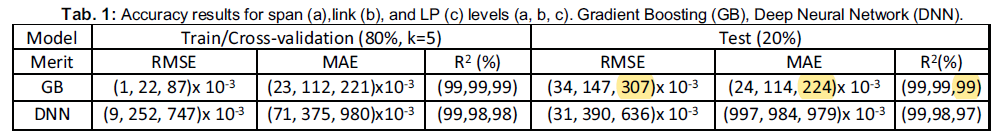

##**Data Visualization on Results**

**Chart Regression**

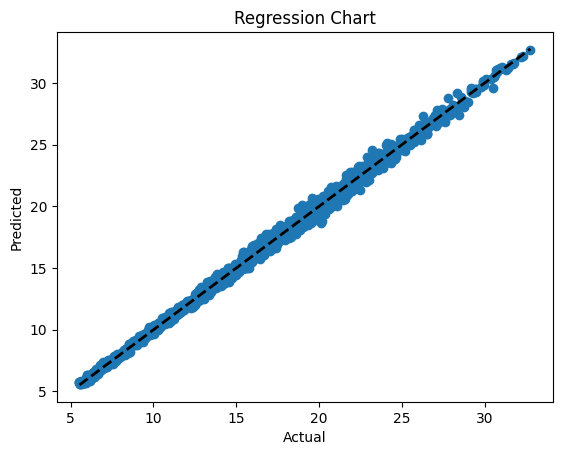

In [55]:
def chart_regression(y_test, y_pred):
    fig, ax = plt.subplots()
    ax.scatter(y_test, y_pred)
    ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')
    ax.set_title('Regression Chart')
    plt.show()

chart_regression(y_test,y_pred.flatten())

**Feature Importance Plot:**

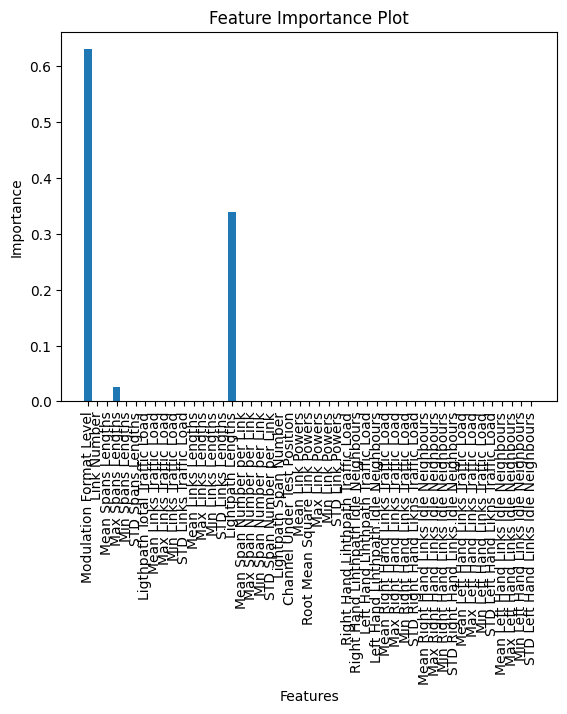

In [43]:
feature_importance = xgb.feature_importances_
feature_names = df.columns[:-1]

plt.bar(feature_names, feature_importance)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance Plot')
plt.xticks(rotation=90)

plt.show()

**Residual Plot:**

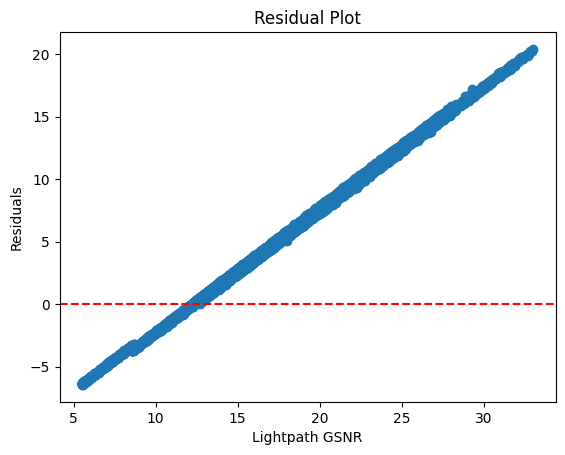

In [46]:
predicted_values = xgb.predict(X)
residuals = df['Lightpath GSNR'] - predicted_values

plt.scatter(df['Lightpath GSNR'], residuals)
plt.xlabel('Lightpath GSNR')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()